# Ensemble Learning

In [128]:
# Bring in mathplotlib and numpy, and select colour
%pylab inline
figsize(10, 8)
colour = ['b-', 'g-', 'r-', 'y-', 'm-', 'c-', 'k-', 'w-', 'b--', 'g--', 'r--', 'y--', 'm--', 'c--', 'k--', 'w--']

# Random package
import random

# for loading the data we will use
from sklearn import datasets, tree

# Cross Validation method k folds.
from sklearn.model_selection import KFold

# Decision tree implementation
from sklearn import tree

# Mode
from scipy.stats import mode

# Time
import time

Populating the interactive namespace from numpy and matplotlib


//anaconda/lib/python3.5/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [4]:
def digit_data():
    # Collect the data from the Sklearn package    
    (X,Y) = datasets.load_digits(return_X_y=True)
    
    # Construct a permutation of the data indexes, evenly split the data into train, test
    permutation = list(range(len(X)))
    random.shuffle(permutation)
    train, test = permutation[:len(X)//2], permutation[len(X)//2:]
    
    # Seperate out the data
    train_data, train_target = X[train], Y[train]
    test_data, test_target = X[test], Y[test]

    # Return the training and test data and targets
    return train_data, train_target, test_data, test_target

In [5]:
def cv(func, d, t, params, funcSig = []):
    """ Recursively step through a function and its possible parameter iteration """
    if params:
        # iterate through path selection
        data = [ cv(func, d, t, params[1:], funcSig + [var]) for var in params[0]]
        return [list(content) for content in zip(*data)]
    else:
        # end of parameters, evaluate and return
        scores = [func(d[f], t[f], d[vf], t[vf], *funcSig) for f, vf in KFold(n_splits=5, shuffle=True).split(d)]
        mean = sum(scores)/len(scores)
        variance = sum([(x - mean)**2 for x in scores])/len(scores)
        return mean, variance

### Decision Tree

In this part you are asked to train a decision tree on the digits data. You should use the implementation of the classification tree in sklearn, which allows you to play with the parameters (read the documentation). Read especially on the max_depth, min_samples_split and min_samples_leaf parameters. 
You should use the digits data available in sklearn as an example. 
In this section you are expected to provide an estimate of the mean variance of the classification accuracy depending on tree depth. Use N-fold cross validation to get these estimates.  


In [22]:
def DecisionTree(Xtr, ttr, Xtv, ttv, max_depth=None, minSplit=2, minSample=1):
    # Create a decision tree classifier machine
    machine = tree.DecisionTreeClassifier(max_depth=max_depth, min_samples_split=minSplit, min_samples_leaf=minSample)
    machine = machine.fit(Xtr, ttr)

    # Predict and return normalised missclassified error
    predictions = machine.predict(Xtv)
    return sum([x != t for x, t in zip(predictions, ttv)])/len(Xtv)

In [23]:
Xtr, ttr, Xte, tte = digit_data()                                  # Load the digit data
treeDepth = range(1,50)                                            # Define parameters
meanError, scoreVariance = cv(DecisionTree, Xtr, ttr, [treeDepth]) # Calculate Score and Variance

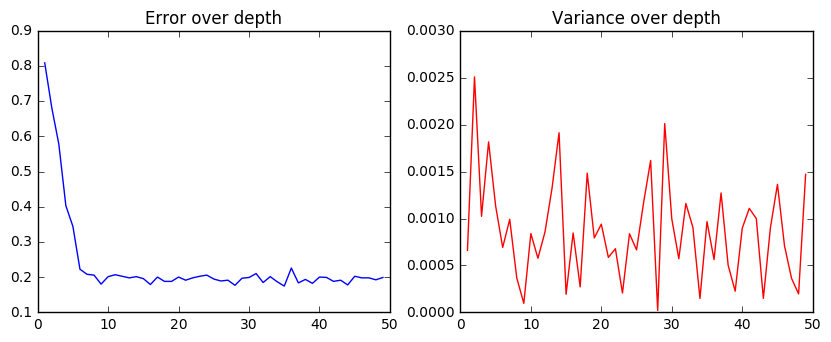

In [26]:
figure()
subplot(221)
title("Error over depth")
plot( treeDepth, meanError, 'b-')

subplot(222)
title("Variance over depth")
plot( treeDepth, scoreVariance, 'r-')

### Testing with split and sample values:

In [10]:
Xtr, ttr, Xte, tte = digit_data()                                                       # Load the digit data
treeDepth, minSplit, minSample = range(1,11), range(2,40), range(2,40)                  # Define parameters
meanScore, scoreVariance = cv(DecisionTree, Xtr, ttr, [treeDepth, minSplit, minSample]) # Calculate Score and Variance

In [11]:
# Collections for the depths best values
splitValues, sampleValues = [], []
splitVariance, sampleVariance = [], []

# Extract the best scores
for index in range(len(treeDepth)):
     
    # Select the current depth information
    depthScore, depthVariance = meanScore[index], scoreVariance[index]
    best, split, sample = 0, 0, 0

    # Iterate through information to identify best score
    for i, collection in enumerate(depthScore):
        if max(collection) > best:
            split, sample = collection.index(max(collection)), i

    # Store the values and variance of the two testing aspect
    splitValues.append([ x[split] for x in depthScore] )
    splitVariance.append([ x[split] for x in depthVariance])
    sampleValues.append(depthScore[sample])
    sampleVariance.append(depthVariance[sample])

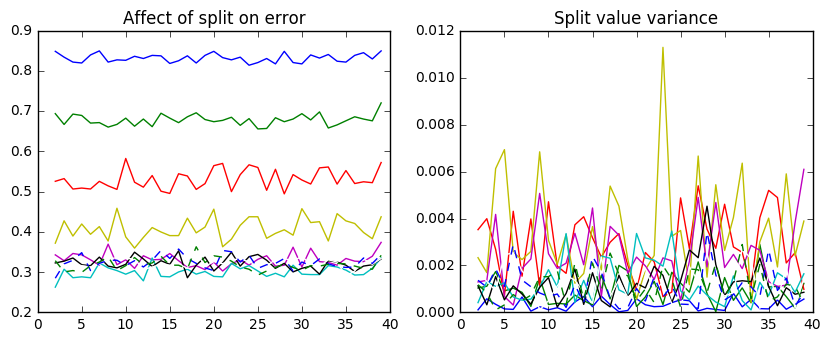

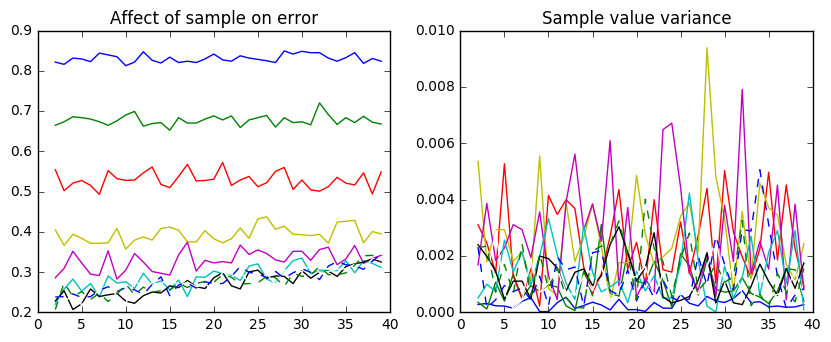

In [13]:
# Plot the findings
figure()
subplot(221)
title("Affect of split on error")
for i, collection in enumerate(splitValues):
    plot(minSplit, collection, colour[i], label="D" + str(treeDepth[i]))
    
subplot(222)
title("Split value variance")
for i, collection in enumerate(splitVariance):
    plot(minSplit, collection, colour[i], label="Depth " + str(treeDepth[i]))
    
    
figure()
subplot(221)
title("Affect of sample on error")
for i, collection in enumerate(sampleValues):
    plot(minSample, collection, colour[i], label="Depth " + str(treeDepth[i]))
    
subplot(222)
title("Sample value variance")
for i, collection in enumerate(sampleVariance):
    plot(minSample, collection, colour[i], label="Depth " + str(treeDepth[i]))

It is clear that primarily the minimum split value does not have a large affect on the error value of the function. Sample error seems to increase as the minimum sample size increases.

### Random Forests
In this part, you are asked to encode yourself a version of random forest based on sklearn implementation of the classification tree (do not use sklearn random forest, implement the bagging yourself). 
Note that you will need to use the tree parameter max_features to do this. 

Once you have coded this, provide a graph of the accuracy curves for different tree depths and forest size. 
Plot the forest size as the x axis, classification error as the y axis, and plot one curve for tree depth of 1,2,5 and 10.
Again, use N-Fold cross-validation to plot error bars on your graph. 


In [63]:
def Random_Forest(Xtr, ttr, Xtv, ttv, tree_depth, forest_size, max_features="auto", sample_size=0.7 ):
    
    # Create predictions for all trees in forest
    predictions = []
    for treeID in range(forest_size):
        
        # Select sample data for this decision tree
        sampleSelection = random.sample(range(len(Xtr)), int(sample_size*len(Xtr)))
        sampleData, sampleTarget = Xtr[sampleSelection], ttr[sampleSelection]
        
        """ My obsolete method for Feature selection, remains as a relic 
        # Identify the features of the data to be used
        featureSize = set(range(shape(Xtr)[1]))
        featureSelection = set(random.sample(range(shape(Xtr)[1]), max_features))
        deletionIndex = list(featureSize.difference(featureSelection))
        
        # Delete unwanted features
        delete(sampleData, deletionIndex, axis=1)
        
        validationData, validationTarget = Xtv, ttv
        delete(validationData, deletionIndex, axis=1)
        """
        
        # Execute and record decision tree output
        machine = tree.DecisionTreeClassifier(max_depth=tree_depth, max_features=max_features)
        machine = machine.fit(sampleData, sampleTarget)
        
        # Predict data and calculate missclassified error
        predictions.append(machine.predict(Xtv))
        
    # Vote for final target prediction via machines
    error = 0
    for i, target in enumerate(ttv):
        if mode([x[i] for x in predictions])[0][0] != target:
            error += 1

    return error/len(ttv)

In [120]:
Xtr, ttr, Xte, tte = digit_data()                                              # Load data
treeDepth, forestSize = [1,2,5,10], range(2,100,2)                             # Construct parameters
meanScore, meanVariance = cv(Random_Forest, Xtr, ttr, [treeDepth, forestSize]) # Run cross validation

Best parameters:
	Depth: 10 	Forest size: 86 	Error: 0.0300744878957


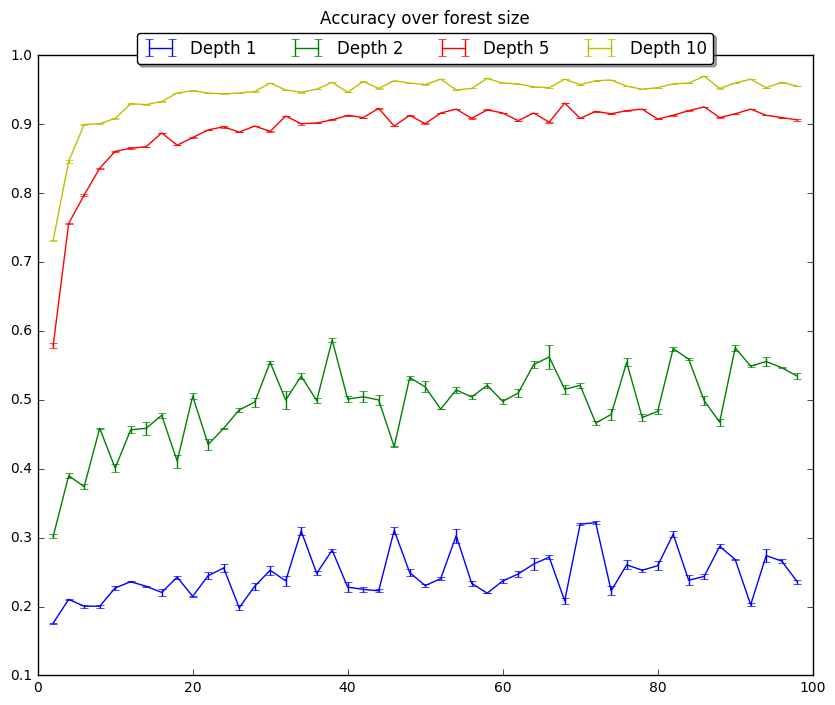

In [124]:
# Idenfity the best parameters from results
best, depth, forest = Inf, 0, 0
for i in range(len(treeDepth)):
    if min(meanScore[i]) < best:
        best = min(meanScore[i])
        depth, forest = i, meanScore[i].index(min(meanScore[i]))
        
randomForestDepth, randomForestSize = treeDepth[depth], forestSize[forest]
print("Best parameters:")
print("\tDepth:", treeDepth[depth], "\tForest size:", forestSize[forest], "\tError:", best)

# Plot results
figure()
title("Accuracy over forest size", y=1.04)
for i in range(len(treeDepth)):
    accuracy = ones(len(forestSize))-meanScore[i]
    errorbar(forestSize, accuracy, meanVariance[i], fmt=colour[i], label="Depth " + str(treeDepth[i]))
legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True, shadow=True)

In [146]:
Xtr, ttr, Xte, tte = digit_data()
treeDepth, forestSize, featureSize = [1,2,5,10], range(2,100,2), range(10,64,2)
meanScore, meanVariance = cv(Random_Forest, Xtr, ttr, [treeDepth, forestSize, featureSize])

Best values for forest and features:
	Depth: 1 	Forest Size: 28  	Feature size: 3 	error: 0.667231533209
	Depth: 2 	Forest Size: 26  	Feature size: 2 	error: 0.440912476723
	Depth: 5 	Forest Size: 45  	Feature size: 1 	error: 0.0545685909373
	Depth: 10 	Forest Size: 47  	Feature size: 1 	error: 0.0300434512725


(9, 64)

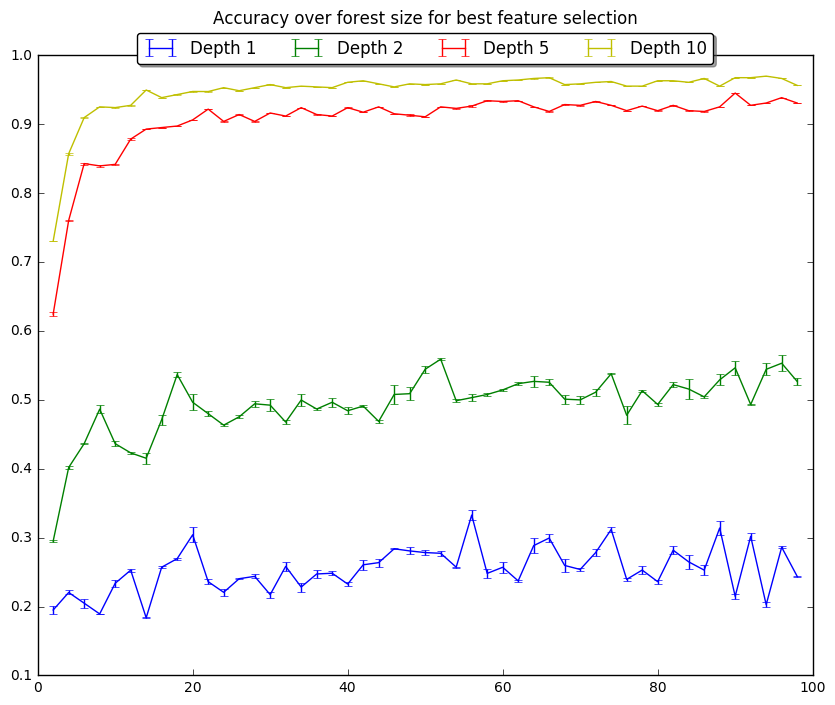

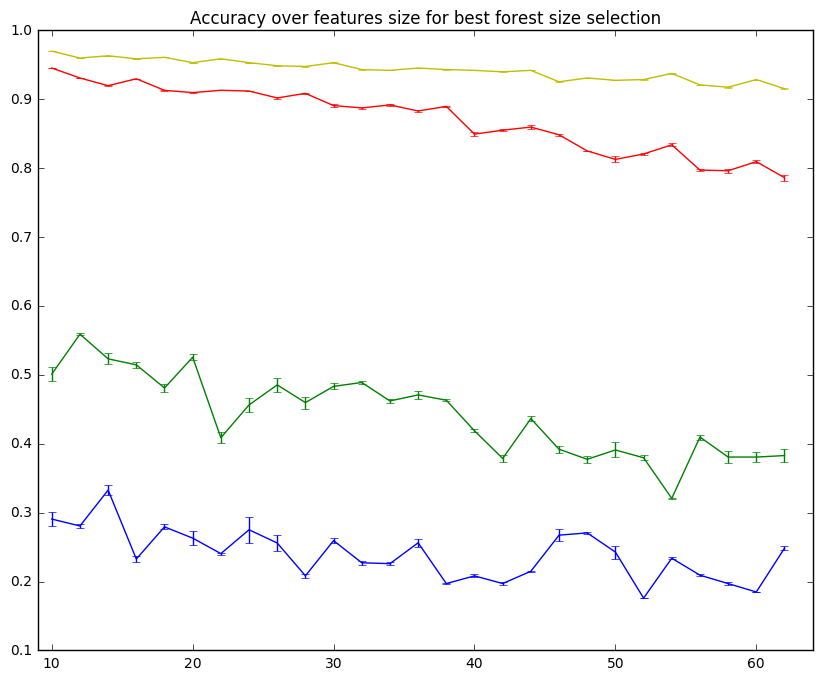

In [148]:
# Extract the best scores
forestValues, featureValues = [], []
forestVar, featureVar = [], []

print("Best values for forest and features:")
for index in range(len(treeDepth)):
     
    # Select the current depth information
    depthScore, depthVariance = meanScore[index], meanVariance[index]
    best, forest, feature = Inf, 0, 0

    # Iterate through information to identify best score
    for i, collection in enumerate(depthScore):
        if min(collection) < best:
            best = min(collection)
            forest, feature = i, collection.index(min(collection))
            
    print("\tDepth:",treeDepth[index], "\tForest Size:",forest+1," \tFeature size:",feature+1, "\terror:", best)
            
    forestValues.append([x[feature] for x in depthScore])
    forestVar.append([x[feature] for x in depthVariance])
    featureValues.append(depthScore[forest])
    featureVar.append(depthVariance[forest])

# Plot results
figure()
title("Accuracy over forest size for best feature selection", y=1.04)
for i in range(len(treeDepth)):
    accuracy = ones(len(forestValues[i]))-array(forestValues[i]) # Convert error to accuracy
    errorbar(forestSize, accuracy, yerr=forestVar[i], fmt=colour[i], label="Depth " + str(treeDepth[i]))
legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True, shadow=True)
    
figure()
title("Accuracy over features size for best forest size selection")
for i in range(len(treeDepth)):
    accuracy = ones(len(featureValues[i]))-array(featureValues[i])
    errorbar(featureSize, accuracy, yerr=featureVar[i], fmt=colour[i])
xlim(9,64)

### Boosting
In this last section you are asked to implement Boosting using sklearn trees as weak learners (again, do not use sklearn boosting algorithms but implement AdaBoost.M1 from scratch). Because boosting does not support multiclass natively, you can select one digit as your target (so called one-versus-old approach).  
Note that you will need to provide the weights to each training samples when calling the trees' fit() method. 

Once you have done this, plot a similar curve as you did before, with boosting rounds as x-axis, classification error as y-axis and one curve for tree depth of 1,2,5 and 10, using N-Fold cross-validation to obtain error bars. 

Finally provide a summary table of the best performance obtained by each algorithm in your experiments, along with the estimated processing time (use the timeit package to measure training time). 

In [108]:
def Ada_Boosting(Xtr, ttr, Xtv, ttv, tree_depth, class_num):
    
    # Initialisation
    weakClassifiers = []  # Classifier store
    N = len(Xtr)          # Number of data items
    weights = ones(N)/N   # Boosting weights
    alpha = []            # Alpha values
    
    # Convert data into binary classes
    selectedDigit = 7
    ttr[ttr != selectedDigit], ttr[ttr == selectedDigit] = -1, 1
    ttv[ttv != selectedDigit], ttv[ttv == selectedDigit] = -1, 1
    
    for classifier in range(class_num):
        
        machine = tree.DecisionTreeClassifier(max_depth=tree_depth)
        machine.fit(Xtr,ttr, sample_weight=weights)
        
        # Make predictions on the data and calculate error
        predictions = machine.predict(Xtr)
        missClass = array([x != t for x, t in zip(predictions, ttr)])
        
        # Find values for error and alpha
        error = (weights*missClass).sum()
        if error:
            alpha = 0.5*log((1-error)/error)
        else:
            # If error is 0 -> log(1/0) ~ 1
            alpha = 0.5
        
        # Readjust the weights
        for i in range(N):
            if missClass[i] == 1:
                weights[i] = weights[i] * exp(alpha)
            else:
                weights[i] = weights[i] * exp(-alpha)   
        weights = weights / weights.sum()
        
        # Store the weak classifier and it's alpha value for later use
        weakClassifiers.append((alpha, machine))
    
    # Use each tree to predict the datapoints
    error = 0
    for i in range(len(Xtv)):
        datapoint, target = Xtv[i], ttv[i]

        
        predictions = [alpha*machine.predict([datapoint]) for alpha, machine in weakClassifiers]
        if sign(sum(predictions)) != target:
            error += 1
            
    return float(error)/N

In [113]:
Xtr, ttr, Xte, tte = digit_data()
treeDepth, num_classifiers = [1,2,5,10], range(1,100,2)
meanError, meanVariance = cv( Ada_Boosting, Xtr, ttr, [treeDepth, num_classifiers] )

Best parameters were:
	Depth: 2 	# of classifiers: 71 	Error: 0.000556715648862


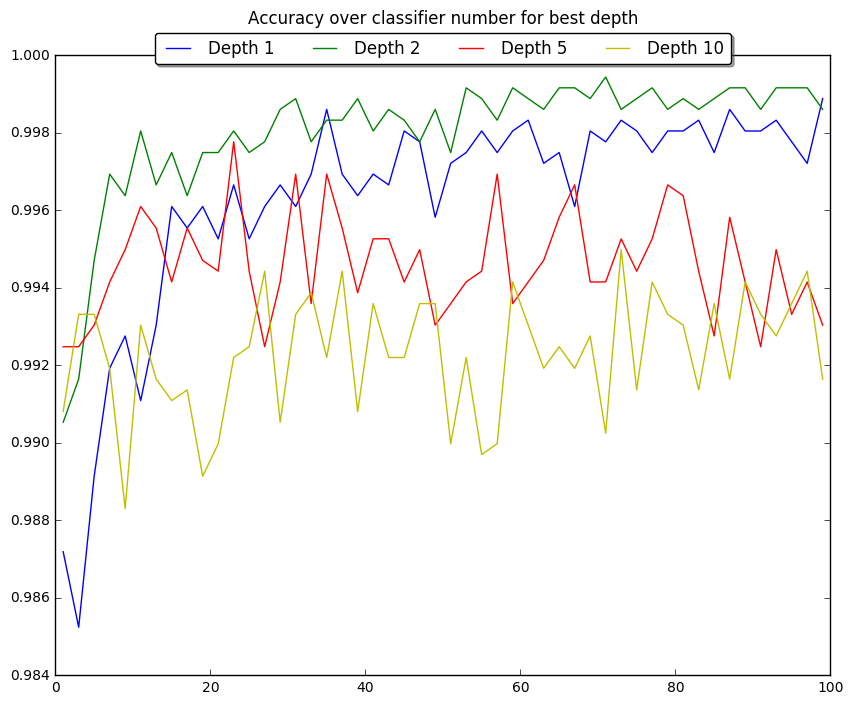

In [119]:
best, depth, class_num = Inf, 0, 0

for i in range(len(treeDepth)):
    if min(meanError[i]) < best:
        best = min(meanError[i])
        depth, class_num = i, meanError[i].index(min(meanError[i]))
        
boostingDepth, boostingClass_num = treeDepth[depth], num_classifiers[class_num]
print("Best parameters were:")
print("\tDepth:", treeDepth[depth], "\t# of classifiers:", num_classifiers[class_num], "\tError:", best)

figure()
title("Accuracy over classifier number for best depth", y=1.04)
for i in range(len(treeDepth)):
    accuracy = ones(len(meanError[i])) - array(meanError[i]) 
    plot( num_classifiers, accuracy, colour[i], label="Depth " + str(treeDepth[i]))
legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=4, fancybox=True, shadow=True)

In [143]:
Xtr, ttr, Xte, tte = digit_data()
bXtr, bttr, bXte, btte = Xtr, ttr, Xte, tte

selectedDigit = 7
bttr[bttr != selectedDigit], bttr[bttr == selectedDigit] = -1, 1
btte[btte != selectedDigit], btte[btte == selectedDigit] = -1, 1

fTimes, bTimes = [], []
fErrors, bErrors = [], []
for i in range(10):
    forestTime = time.time()
    error = Random_Forest(Xtr, ttr, Xte, tte, randomForestDepth, randomForestSize)
    forestTime = time.time() - forestTime
    fTimes.append(round(forestTime,3))
    fErrors.append(error)

    boostingTime = time.time()
    error = Ada_Boosting(bXtr, bttr, bXte, btte, boostingDepth, boostingClass_num)
    boostingTime = time.time() - boostingTime
    bTimes.append(round(boostingTime,3))
    bErrors.append(error)

print("\tForest \n\t\ttimes:", str(fTimes), "\tAvg:", sum(fTimes)/len(fTimes), "\n\t\tError:", sum(fErrors)/len(fErrors))
print("\tBoosting \n\t\ttimes:", str(bTimes), "\tAvg:", sum(bTimes)/len(bTimes), "\n\t\tError:", sum(bErrors)/len(bErrors))

	Forest 
		times: [0.186, 0.144, 0.144, 0.148, 0.144, 0.146, 0.147, 0.148, 0.144, 0.145] 	Avg: 0.1496 
		Error: 0.000889877641824
	Boosting 
		times: [2.569, 2.542, 2.534, 2.529, 2.518, 2.533, 2.588, 2.616, 2.593, 2.626] 	Avg: 2.5648 
		Error: 0.0
